In [11]:
# Hugging Face dataset bootstrapping
OWNER_NAME = 'competitions/'
DATASET_NAME = 'aiornot'

!pip install -Uqq datasets
!pip install -Uqq python-dotenv

from dotenv import load_dotenv
import os
from pathlib import Path
from datasets import load_dataset


load_dotenv('/notebooks/.env')
access_token = os.environ.get('HF_TOKEN')
DOWNLOADS = Path('downloads')
path = DOWNLOADS/DATASET_NAME

print('about to download', OWNER_NAME+DATASET_NAME, 'to', DOWNLOADS)
ds = load_dataset(OWNER_NAME+DATASET_NAME, use_auth_token=access_token)
print('done')

about to download competitions/aiornot to downloads


Using custom data configuration competitions--aiornot-c64672d1851055ac
Found cached dataset parquet (/root/.cache/huggingface/datasets/competitions___parquet/competitions--aiornot-c64672d1851055ac/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

done


## Data preprocessing
Moving csv format to images in folders

In [12]:
from datasets import Image as ImageFeature
ds = ds.cast_column('image', ImageFeature())
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'label'],
        num_rows: 18618
    })
    test: Dataset({
        features: ['id', 'image', 'label'],
        num_rows: 43442
    })
})

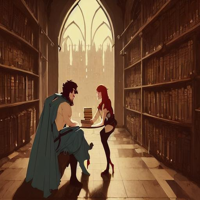

In [13]:
sample_img = ds['train'][1337]['image']
sample_img.thumbnail((200,200))
sample_img

In [14]:
ds['train'].info

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value(dtype='string', id=None), 'image': Image(decode=True, id=None), 'label': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='parquet', config_name='competitions--aiornot', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=710871444, num_examples=18618, shard_lengths=None, dataset_name='parquet'), 'test': SplitInfo(name='test', num_bytes=1665842505, num_examples=43442, shard_lengths=[20861, 21721, 860], dataset_name='parquet')}, download_checksums={'https://huggingface.co/datasets/competitions/aiornot/resolve/799af3344961cbc8bd71c8151db06700e222d9d2/data/train-00000-of-00002-9767f7576a73674b.parquet': {'num_bytes': 353957464, 'checksum': '44bfa05ca357a020877248ea205a3d82cdd0494b6671b4c607dad34a6dd9df58'}, 'https://huggingface.co/datasets/competitions/aiornot/resolve/799af3344961cbc8bd71c8151db06700e222d9d2/data/train-00001-of-0

Let's save the dataset in folders 

In [16]:
path

PosixPath('downloads/aiornot')

In [17]:
path.mkdir(exist_ok=True)

In [18]:
df = ds['train'].to_pandas()
df.head()

,id,image,label
0,0.jpg,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1
1,1.jpg,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1
2,2.jpg,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1
3,3.jpg,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,4.jpg,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1


<AxesSubplot:>

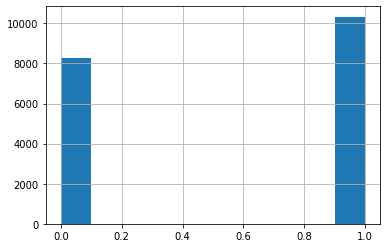

In [19]:
df.label.hist()

In [20]:
test_df = ds['test'].to_pandas()
test_df[['id', 'label']].head()

,id,label
0,0.jpg,-1
1,1.jpg,-1
2,2.jpg,-1
3,3.jpg,-1
4,4.jpg,-1


In [21]:
(path/'train'/'0').mkdir(exist_ok=True)
(path/'train'/'1').mkdir(exist_ok=True)
(path/'test'/'0').mkdir(exist_ok=True)
(path/'test'/'1').mkdir(exist_ok=True)

In [22]:
ds['train'][:2]['id']

['0.jpg', '1.jpg']

In [140]:
from PIL import Image
from tqdm.auto import tqdm

# save train images to folder
for i, fname in tqdm(enumerate(ds['train']['id']), total=ds['train'].num_rows):
    img = ds['train'][i]['image']
    label = str(ds['train'][i]['label'])
    fpath = path/'train'/label/fname
    #print(fpath)
    if not fpath.is_file():
        img.save(fpath)

  0%|          | 0/18618 [00:00<?, ?it/s]

In [156]:
# save test images to folder
# TODO: run!
for i, fname in tqdm(enumerate(ds['test']['id']), total=ds['test'].num_rows):
    img = ds['test'][i]['image']
    label = str(ds['test'][i]['label'])
    fpath = path/'test'/fname
    #print(fpath)
    if not fpath.is_file():
        img.save(fpath)

  0%|          | 0/43442 [00:00<?, ?it/s]

### let's use a jucier model from timm 

In [23]:
# gpu memory management
import gc, torch
!pip install -Uqq pynvml

def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [27]:
!pip install -Uqq timm

import timm 

In [28]:
from fastai.vision.all import *

files = get_image_files(path/'train')
len(files)

18618

In [32]:
# check image sizes fast
from fastcore.parallel import *

def get_image_size(o): return PILImage.create(o).size

# files = get_image_files(path)
sizes = parallel(get_image_size, files, n_workers=8)
pd.Series(sizes).value_counts()

(512, 512)    18618
dtype: int64

All images are of size (512,512)

In [35]:
dls = ImageDataLoaders.from_folder(path/'train', valid_pct=0.2,
    item_tfms=Resize(420),
    #batch_tfms=aug_transforms(size=128, min_scale=0.5, do_flip=True)
    batch_tfms=aug_transforms(size=55, min_scale=0.75), # fast small image training
)
print(len(dls.train), len(dls.valid))

232 59


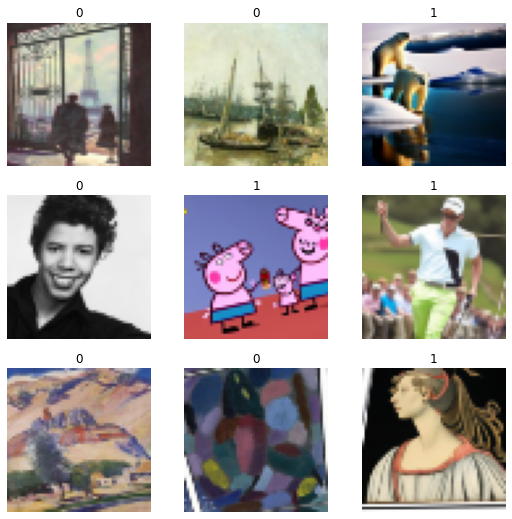

In [36]:
dls.show_batch()

## Let's build a big model!

In [37]:
learn = vision_learner(dls, 'convnext_large_in22k', 
            metrics=error_rate, loss_func=LabelSmoothingCrossEntropy(),
                      cbs = GradientAccumulation(64) if accum else []).to_fp16()

SuggestedLRs(valley=0.0020892962347716093)

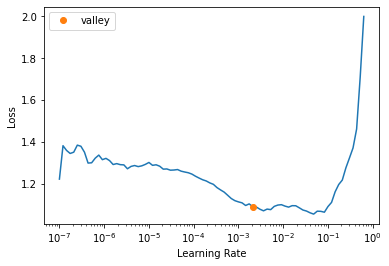

In [38]:
learn.lr_find()

In [39]:
learn.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.638366,0.478370,0.155520,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.449334,0.389518,0.113618,00:55
1,0.380179,0.356620,0.098039,00:54
2,0.361515,0.351129,0.092130,00:54


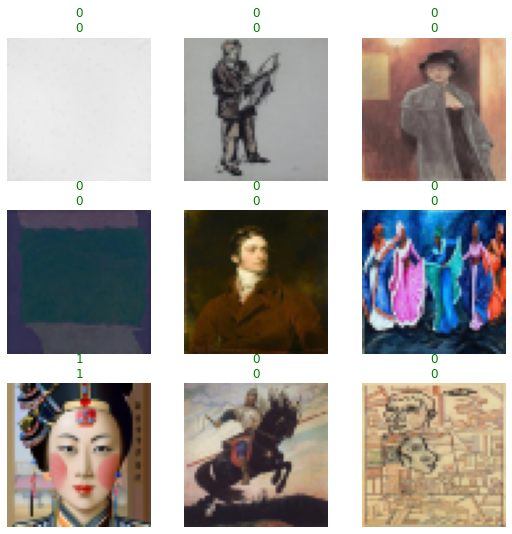

In [41]:
learn.show_results()

In [43]:
# increase image size
mid_dls = ImageDataLoaders.from_folder(path/'train', valid_pct=0.2,
    item_tfms=Resize(420),
    batch_tfms=aug_transforms(size=128, min_scale=0.5)
)
print(len(mid_dls.train), len(mid_dls.valid))

232 59


In [44]:
learn.dls = mid_dls

SuggestedLRs(valley=4.365158383734524e-05)

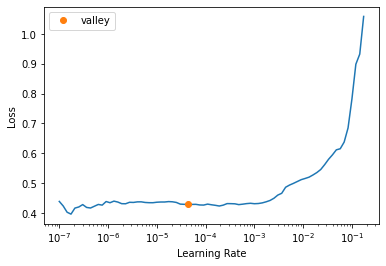

In [45]:
learn.lr_find()

In [47]:
learn.fine_tune(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.330353,0.323007,0.072791,02:13


epoch,train_loss,valid_loss,error_rate,time
0,0.303222,0.300062,0.058824,03:59


In [98]:
report_gpu()

GPU:0
process      32232 uses    12545.000 MB GPU memory


In [89]:
# increase image size one more time
big_dls = ImageDataLoaders.from_folder(path/'train', valid_pct=0.2,
    item_tfms=Resize(420),
    batch_tfms=aug_transforms(size=256, min_scale=0.5),
    bs=16
)
print(len(big_dls.train), len(big_dls.valid))

930 233


In [90]:
learn.dls = big_dls

In [93]:
learn.fine_tune(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.347617,0.292253,0.051303,08:40


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

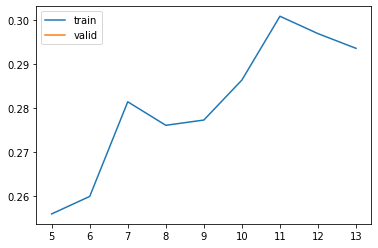

In [94]:
learn.recorder.plot_loss()

In [96]:
preds_tta, y = learn.tta()

0.9540693163871765

In [97]:
error_rate(preds_tta, y).item()

0.045930683612823486

### Interpretations

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,4), dpi=60)

In [159]:
interp.most_confused(min_val=5)

[('0', '1', 91), ('1', '0', 29)]

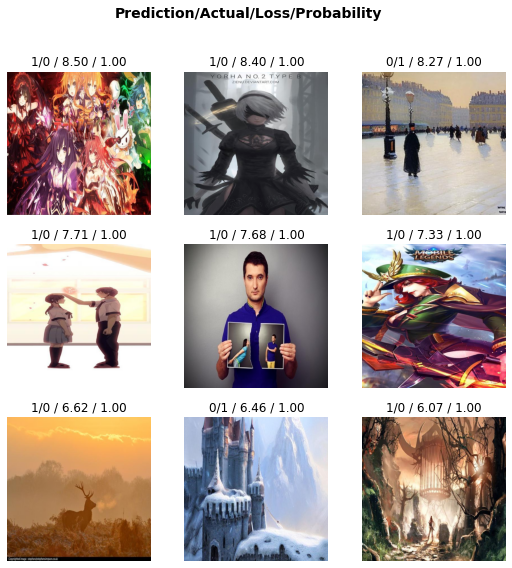

In [160]:
interp.plot_top_losses(9)

## Evaluate on test files

In [99]:
test_files = get_image_files(path/'test')
len(test_files)

43442

In [100]:
test_dl = learn.dls.test_dl(test_files)
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

KeyboardInterrupt: 

In [ ]:
preds[:, 1]

In [ ]:
len(decoded)

## Prepare submission file

In [ ]:
submission = pd.read_csv(path/'sample_submission.csv')
submission.shape

In [ ]:
submission.label = preds[:, 1]
submission

In [ ]:
submission.label.mean()

## Submit CSV to Hugging Face

In [188]:
# write submission csv
technique = '-convnext_large_in22k progressive undecoded-'
sub_filename = Path('subs')/(DATASET_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)
print('done')

done
